In [176]:
import os
os.chdir(os.environ.get('PROJECT_PATH'))
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from traindelays.ml_logic import preprocess as p
from traindelays import utils as u
from traindelays.params import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.dummy import DummyRegressor


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Table of contents**<a id='toc0_'></a>    
- [Features Construction](#toc1_)    
  - [Loading the Data](#toc1_1_)    
  - [Temporal Features](#toc1_2_)    
  - [Geographical Features](#toc1_3_)    
  - [Categorical features](#toc1_4_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Loading the Data](#toc0_)

Loading whole dataset from Google Cloud Platform.

In [93]:
df = u.read_data_from_bq(credentials=SERVICE_ACCOUNT,gcp_project=GCP_PROJECT,bq_dataset=BQ_DATASET,table=RAIL_DATA_TABLE_ID)
df.head()

,FINANCIAL_YEAR_AND_PERIOD,ORIGIN_DEPARTURE_DATE,TRUST_TRAIN_ID_AFFECTED,PLANNED_ORIG_LOC_CODE_AFF,PLANNED_ORIG_WTT_DATETIME_AFF,PLANNED_ORIG_GBTT_DATETIME_AFF,PLANNED_DEST_LOC_CODE_AFFECTED,PLANNED_DEST_WTT_DATETIME_AFF,PLANNED_DEST_GBTT_DATETIME_AFF,TRAIN_SERVICE_CODE_AFFECTED,...,INCIDENT_EQUIPMENT,INCIDENT_DESCRIPTION,REACTIONARY_REASON_CODE,INCIDENT_RESPONSIBLE_TRAIN,RESP_TRAIN,REACT_TRAIN,START_STANOX,END_STANOX,EVENT_DATETIME,PFPI_MINUTES
0,2021/22_P04,03-Jul-21,722C28MK03,72000,2021-03-07 12:15:00+00:00,2021-03-07 12:15:00+00:00,72410,2021-03-07 13:05:00+00:00,2021-03-07 13:05:00+00:00,22216000,...,221108,9M50 3 LATE START EDB,YD,None,None,361A27MH03,72311,72410,2021-03-07 13:09:00+00:00,4.0
1,2019/20_P12,05-Feb-20,522Y48M805,52226,2020-05-02 22:14:00+00:00,2020-05-02 22:14:00+00:00,87219,2020-05-02 23:21:00+00:00,2020-05-02 23:21:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YI,2C28,062C28MI05,872N45M705,52226,52226,2020-05-02 22:23:00+00:00,9.0
2,2019/20_P12,05-Feb-20,522N36MY05,52226,2020-05-02 19:59:00+00:00,2020-05-02 19:59:00+00:00,87132,2020-05-02 21:01:00+00:00,2020-05-02 21:01:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YD,2C28,062C28MI05,516V35CX05,52226,52045,2020-05-02 20:12:00+00:00,4.0
3,2019/20_P12,05-Feb-20,522Y28MY05,52226,2020-05-02 19:53:00+00:00,2020-05-02 19:53:00+00:00,87219,2020-05-02 20:54:00+00:00,2020-05-02 20:55:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YI,2C28,062C28MI05,872N23MX05,52226,52226,2020-05-02 19:55:00+00:00,2.0
4,2019/20_P12,05-Feb-20,872N23MX05,87132,2020-05-02 18:45:00+00:00,2020-05-02 18:45:00+00:00,52226,2020-05-02 19:47:00+00:00,2020-05-02 19:47:00+00:00,22214000,...,334014,2C28 UNIT FLT WES,YB,2C28,062C28MI05,664L57CL05,72419,72421,2020-05-02 19:27:00+00:00,3.0


Data is splitted according to their index, in order to have a stable train/test split.

In [148]:
train, test = u.split_train_test_by_id(data = df, test_ratio = 0.33, id_column = 'index')
X_train =train.drop(columns=['PFPI_MINUTES'])
X_test = test.drop(columns=['PFPI_MINUTES'])
y_train = train['PFPI_MINUTES']
y_test = test['PFPI_MINUTES']

The features are preprocessed.

In [149]:
p.pipe.fit(X_train)
X_train_preproc =p.pipe.transform(X_train)
X_test_preproc =  p.pipe.transform(X_test)

Inspecting the dependant variable

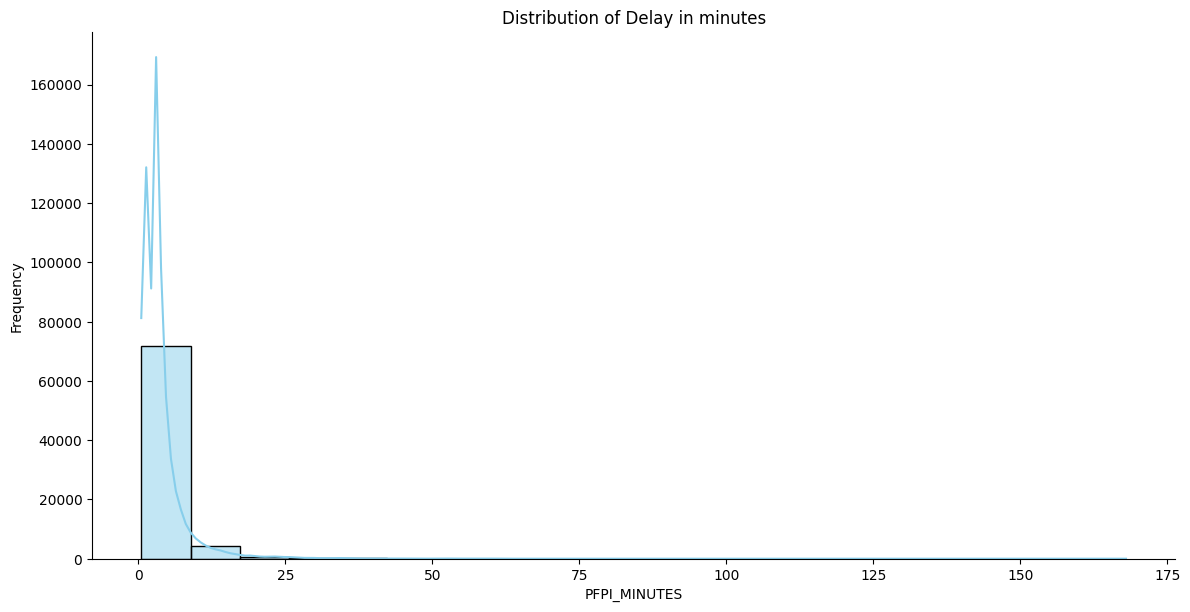

In [151]:
sns.displot(data=y_train, bins = 20, kde=True, color='skyblue', height=6, aspect=2)
plt.title('Distribution of Delay in minutes')
plt.ylabel('Frequency')
plt.show()


## Dummy model

In [174]:
dummy_model = DummyRegressor(strategy="mean")
# Define a custom scoring function for RMSE
def rmse_scorer(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Perform cross-validation using RMSE as the scoring metric
cv_scores = cross_val_score(dummy_model, X_train_preproc, np.log(y_train), cv=5, scoring=make_scorer(rmse_scorer))

# Print the mean and standard deviation of the RMSE scores
print(f'Mean RMSE: {np.exp(np.mean(cv_scores))}')
print(f'All folds RMSEs: {np.exp(cv_scores)}')

Mean RMSE: 2.154574297736384
All folds RMSEs: [2.15157983 2.15286926 2.16013715 2.16724982 2.14112464]


## Baseline Model

In [175]:
baseline_model = LinearRegression()

# Perform cross-validation using RMSE as the scoring metric
cv_scores = cross_val_score(baseline_model, X_train_preproc, np.log(y_train), cv=5, scoring=make_scorer(rmse_scorer))

# Print the mean and standard deviation of the RMSE scores
print(f'Mean RMSE: {np.exp(np.mean(cv_scores))}')
print(f'All folds RMSEs: {np.exp(cv_scores)}')

Mean RMSE: 1.8520509705973125
All folds RMSEs: [1.84641514 1.85625762 1.85180734 1.86084427 1.84497821]
